In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import random as random
from casadi import *

In [2]:
n = 500
T = 1
taux = T/n

Times = np.linspace(0, T, n)

In [3]:
####################################### KKT

######################## DOC

def Katja_Mombaur_DOC ( Xi, Xf, alpha1, alpha2, alpha3):
    xi = Xi[0] 
    yi = Xi[1]
    thetai = Xi[2]
    
    xf = Xf[0] 
    yf = Xf[1]
    thetaf = Xf[2]
    
    opti = casadi.Opti()   

    ## les positions
    x = opti.variable(n)
    y = opti.variable(n)
    theta = opti.variable(n)

    ## les vitesses 
    v1 = opti.variable(n)        ## vitesse latérale
    v2 = opti.variable(n)        ## vitesse orthogonal
    w = opti.variable(n)         ## vitesse angulaire
    
        ## les vitesses 
    u1 = opti.variable(n)        ## accélération latérale
    u3 = opti.variable(n)        ## accélération orthogonal
    u2 = opti.variable(n)        ## accélération angulaire
    
    
    
    opti.minimize(  taux*(alpha1 * dot(u1,u1) + alpha2 * dot(u2,u2 ) + alpha3 * dot( u3 ,u3 ) ) )    # ma fonction objetion

    # mes fonctions de contrainte d'égalité:

    ## pour les condition initial
    opti.subject_to( x[0] == xi + 10**(-4))        
    opti.subject_to( y[0] == yi + 10**(-4))
    opti.subject_to( theta[0] == thetai + 10**(-4))
    
    
    opti.subject_to( v1[0] == 10**(-4) )
    opti.subject_to( w[0]  == 10**(-4) )
    opti.subject_to( v2[0] == 10**(-4) )
    opti.subject_to( v1[-1] == 10**(-4) )
    opti.subject_to( w[-1]  == 10**(-4) )
    opti.subject_to( v2[-1] == 10**(-4) )
    
    opti.subject_to( u1[-1] == 10**(-4) )
    opti.subject_to( u2[-1] == 10**(-4) )
    opti.subject_to( u3[-1] == 10**(-4) )
    opti.subject_to( u1[0] == 10**(-4) )
    opti.subject_to( u2[0] == 10**(-4) )
    opti.subject_to( u3[0] == 10**(-4) )



    ## pour les contraintes d'égaliter
    opti.subject_to( x[1:] + 10**(-4) == x[:n-1]+taux*(cos(theta[:n-1])*v1[:n-1] - sin(theta[:n-1])*v2[:n-1]) )
    opti.subject_to( y[1:] + 10**(-4) == y[:n-1]+taux*(sin(theta[:n-1])*v1[:n-1] + cos(theta[:n-1])*v2[:n-1]) )
    opti.subject_to( theta[1:] + 10**(-4) == theta[:n-1] + taux*w[:n-1] )
    opti.subject_to( (v1[:n-1] + taux* u1[:n-1] == v1[1:] + 10**(-4))  )
    opti.subject_to( (v2[:n-1] + taux* u3[:n-1] == v2[1:] + 10**(-4)) )
    opti.subject_to( (w[:n-1] + taux* u2[:n-1] == w[1:] + 10**(-4)) )
    

    ## pour les conditions finales
    opti.subject_to( x[-1]==xf + 10**(-4))
    opti.subject_to( y[-1]==yf + 10**(-4))
    opti.subject_to( theta[-1]==thetaf + 10**(-4))


    opti.solver('ipopt')      


    sol = opti.solve()
    
    
    X = sol.value(x)
    Y = sol.value(y)
    THETA = sol.value(theta)
    
    V1 = sol.value(v1)
    V2 = sol.value(v2)
    W = sol.value(w)
    
    U1 = sol.value(u1)
    U2 = sol.value(u2)
    U3 = sol.value(u3)
    
    return X,Y,THETA, V1,V2,W, U1,U2,U3


In [4]:
####################### IOC


xi = SX.sym('xi',1)                   
yi = SX.sym('yi',1)                
thetai = SX.sym('thetai',1)


xf = SX.sym('xf',1)
yf = SX.sym('yf',1)
thetaf = SX.sym('thetaf',1)

alpha1 = SX.sym('alpha1',1)
alpha2 = SX.sym('alpha2',1)
alpha3 = SX.sym('alpha3',1)

## Position
x=SX.sym('x',n)
x_prime = SX.sym('x_prime', n+1)
x_prime[0] = x[0]
x_prime[1:] =x


y=SX.sym('y',n)
y_prime = SX.sym('y_prime', n+1)
y_prime[0] = y[0]
y_prime[1:] =y

theta=SX.sym('theta',n)
theta_prime = SX.sym('theta_prime', n+1)
theta_prime[0] = theta[0]
theta_prime[1:] =theta

## Vitesse
v1=SX.sym('v1',n)  
v1_prime = SX.sym('v1_prime', n+1)
v1_prime[0] = 0
v1_prime[n] = 0
v1_prime[1:n] =v1[0:n-1]

v1_prime_1 = SX.sym('v1_prime_1', n+1)
v1_prime_1[0] = v1[0]
v1_prime_1[1:] =v1


v2=SX.sym('v2',n)  
v2_prime = SX.sym('v2_prime', n+1)
v2_prime[0] = 0
v2_prime[n] = 0
v2_prime[1:n] =v2[0:n-1]

v2_prime_1 = SX.sym('v2_prime_1', n+1)
v2_prime_1[0] = v2[0]
v2_prime_1[1:] =v2


w=SX.sym('w',n)  
w_prime = SX.sym('w_prime', n+1)
w_prime[0] = 0
w_prime[n] = 0
w_prime[1:n] =w[0:n-1]

w_prime_1 = SX.sym('w_prime_1', n+1)
w_prime_1[0] = w[0]
w_prime_1[1:] =w

## Accélération 

u1=SX.sym('u1',n)  
u1_prime = SX.sym('u1_prime', n+1)
u1_prime[0] = 0
u1_prime[n] = 0
u1_prime[1:n] = u1[0:n-1]

u2=SX.sym('u2',n)  
u2_prime = SX.sym('u2_prime', n+1)
u2_prime[0] = 0
u2_prime[n] = 0
u2_prime[1:n] = u2[0:n-1]

u3=SX.sym('u3',n)  
u3_prime = SX.sym('u3_prime', n+1)
u3_prime[0] = 0
u3_prime[n] = 0
u3_prime[1:n] = u3[0:n-1]

Lambda = SX.sym('Lambda',n+3, 6)


p1=vertcat(xi + 10**(-4) ,x_prime[2:] + 10**(-4) ,xf + 10**(-4) )   
h= Function('h',[x, xi, xf],[p1])
p2=vertcat(0, v1)   
K = Function('K', [v1], [p2])
p =vertcat(v1[1:],0) + 10**(-4)
g = Function ('g',[v1],[p])


Y1_K = (x_prime+taux*(v1_prime*cos(theta_prime) - v2_prime*sin(theta_prime)) - h(x, xi,xf))
Y2_K = (y_prime+taux*(v1_prime*sin(theta_prime) + v2_prime*cos(theta_prime)) - h(y, yi,yf)) 
Y3_K = (theta_prime+taux*w_prime - h(theta, thetai,thetaf))

U1 = (g(v1)-v1)/taux - u1
U2 = (g(w)-w)/taux  - u2
U3 = (g(v2)-v2)/taux  - u3 

Y4_K = K(U1) 
Y5_K = K(U2)
Y6_K = K(U3)



Y_K = SX.sym('Y_K',n+1 , 6)        ## notre contrainte

for i in range (0,n+1):
    Y_K[i,0]= Y1_K[i]
    Y_K[i,1]= Y2_K[i]
    Y_K[i,2]= Y3_K[i]       
    Y_K[i,3]= Y4_K[i]       
    Y_K[i,4]= Y5_K[i]       
    Y_K[i,5]= Y6_K[i]       
    
## notre terme qui est relié a la contrainte.
G_lambda = 0

for i in range (n+1):
    G_lambda += dot(Y_K[i,:], Lambda[i,:])
    
G_lambda += (v1[0]-10**(-4))*Lambda[n+1,0] + (w[0]-10**(-4))*Lambda[n+1,1] + (v2[0]-10**(-4))*Lambda[n+1,2] 
G_lambda += (v1[-1]-10**(-4))*Lambda[n+1,3] + (w[-1]-10**(-4))*Lambda[n+1,4] + (v2[-1]-10**(-4))*Lambda[n+1,5] 

G_lambda += (u1[0]-10**(-4))*Lambda[n+2,0] + (u2[0]-10**(-4))*Lambda[n+2,1] + (u3[0]-10**(-4))*Lambda[n+2,2] 
G_lambda += (u1[-1]-10**(-4))*Lambda[n+2,3] + (u2[-1]-10**(-4))*Lambda[n+2,4] + (u3[-1]-10**(-4))*Lambda[n+2,5] 


F_val_K =  taux*( alpha1 * dot(u1,u1) + alpha2 * dot(u2,u2) + alpha3 * dot(u3,u3))

## le Lagrangien 
L_val_K = F_val_K + G_lambda


In [5]:
grad_L_K = SX.zeros(9, n)
for i in range (n):
    grad_L_K[0,i]= jacobian(L_val_K, v1[i])
    grad_L_K[1,i]= jacobian(L_val_K, w[i])
    grad_L_K[2,i]= jacobian(L_val_K, v2[i])
    grad_L_K[3,i]= jacobian(L_val_K, x[i])
    grad_L_K[4,i]= jacobian(L_val_K, y[i])
    grad_L_K[5,i]= jacobian(L_val_K, theta[i])
    grad_L_K[6,i]= jacobian(L_val_K, u1[i])
    grad_L_K[7,i]= jacobian(L_val_K, u2[i])
    grad_L_K[8,i]= jacobian(L_val_K, u3[i])
    
    
    
R_K = Function ('R_K', [u1,u2,u3,v1,w,v2,x,y,theta, Lambda, alpha1, alpha2, alpha3 ,xi,yi,thetai, xf,yf,thetaf  ], [dot(grad_L_K,grad_L_K)])

In [6]:
def Katja_Mombaur_IOC (R_K,U1,U2,U3 ,V1,V2,W,X,Y,THETA,Xi,Xf) :
    xi = Xi[0] 
    yi = Xi[1]
    thetai = Xi[2]
    
    xf = Xf[0] 
    yf = Xf[1]
    thetaf = Xf[2]
    
    
    opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

    alpha1 = opti.variable()
    alpha2 = opti.variable()
    alpha3 = opti.variable()
    Lambda = opti.variable(n+3,6)

    
    
    opti.minimize( R_K(U1,U2,U3,V1,W,V2,X,Y,THETA, Lambda, alpha1, alpha2, alpha3, xi,yi,thetai, xf,yf,thetaf  )) 

    opti.subject_to( 0 <= alpha1)
    opti.subject_to( 0 <= alpha2 )
    opti.subject_to( 0 <= alpha3 )
    opti.subject_to(  alpha1 + alpha2 + alpha3 == 1)

    opti.solver('ipopt')    

    sol = opti.solve()
    
    Alpha1 = sol.value (alpha1)
    Alpha2 = sol.value (alpha2)   
    Alpha3 = sol.value (alpha3)
    
    return Alpha1, Alpha2, Alpha3 , sol.value(Lambda)

In [12]:
Xi = [-4,-0.9,pi]
Xf = [0,0,pi/2]
alpha1 = 0.13
alpha2 = 0.72
alpha3 = 0.15

X,Y,THETA,V1,W,V2,U1,U2,U3 = Katja_Mombaur_DOC ( Xi, Xf, alpha1, alpha2, alpha3)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    10996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2997

Total number of variables............................:     4500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3012
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [13]:
a1,a2,a3, Lambda = Katja_Mombaur_IOC (R_K,U1,U2,U3 ,V1,V2,W,X,Y,THETA,Xi,Xf)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        3
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:    15021

Total number of variables............................:     3021
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        3
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [14]:
a1,a2,a3

(0.06556744131143835, 0.8694511808195727, 0.06498137786898894)

In [15]:
x,y,o,v1,w,v2,u1,u2,u3 = Katja_Mombaur_DOC ( Xi, Xf, a1, a2, a3)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    10996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2997

Total number of variables............................:     4500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3012
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

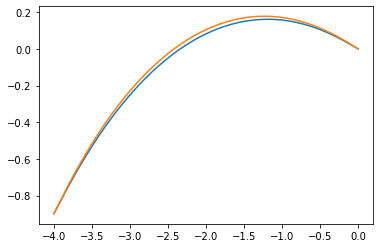

In [16]:
plt.plot(X,Y)
plt.plot(x,y)